In [1]:
import os
import sys
import re
import pickle
import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import scipy.sparse
import gc

In [2]:
sc.set_figure_params(dpi=150)

In [3]:
adata = sc.read("/storage/data/organoid_atlas_adatas/230620_braun_data/braun_2022_fetal_brain_v2_common_hv2k.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 1653974 × 2000
    obs: 'Age', 'CellClass', 'CellCycleFraction', 'CellID', 'Chemistry', 'Clusters', 'Donor', 'DoubletFlag', 'DoubletScore', 'Region', 'SampleID', 'Sex', 'Subdivision', 'Subregion', 'Tissue', 'TopLevelCluster', 'TotalUMIs', 'region_class', 'subregion_class', 'n_genes', '_scvi_batch', '_scvi_labels'
    var: 'Accession', 'Chromosome', 'End', 'Gene', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p'
    layers: 'counts'

In [5]:
embedding = pd.read_csv("/storage/data/organoid_atlas_adatas/230620_braun_data/full_nolabs_latent.tsv", sep="\t", index_col=0)
embedding = embedding.loc[[i.endswith("-1") for i in embedding.index]].copy()
embedding.index = embedding.index.str[:-2]
adata.obsm["X_scanvi"] = embedding.loc[adata.obs.index].values

In [6]:
umap = pd.read_csv("/storage/data/organoid_atlas_adatas/230620_braun_data/full_nolabs_umap.tsv", sep="\t", index_col=0)
umap = umap.loc[[i.endswith("-1") for i in umap.index]].copy()
umap.index = umap.index.str[:-2]
adata.obsm["X_umap_scanvi_scarches"] = umap.loc[adata.obs.index].values

In [8]:
assert np.all(adata.obs.index.values == np.load("/storage/data/organoid_atlas_adatas/230620_braun_data/cell_labels.npy", allow_pickle=True))
adata.obsm["X_umap_scanvi_scarches"] = np.load("/storage/data/organoid_atlas_adatas/230620_braun_data/embed_umap_scanvi.npy")

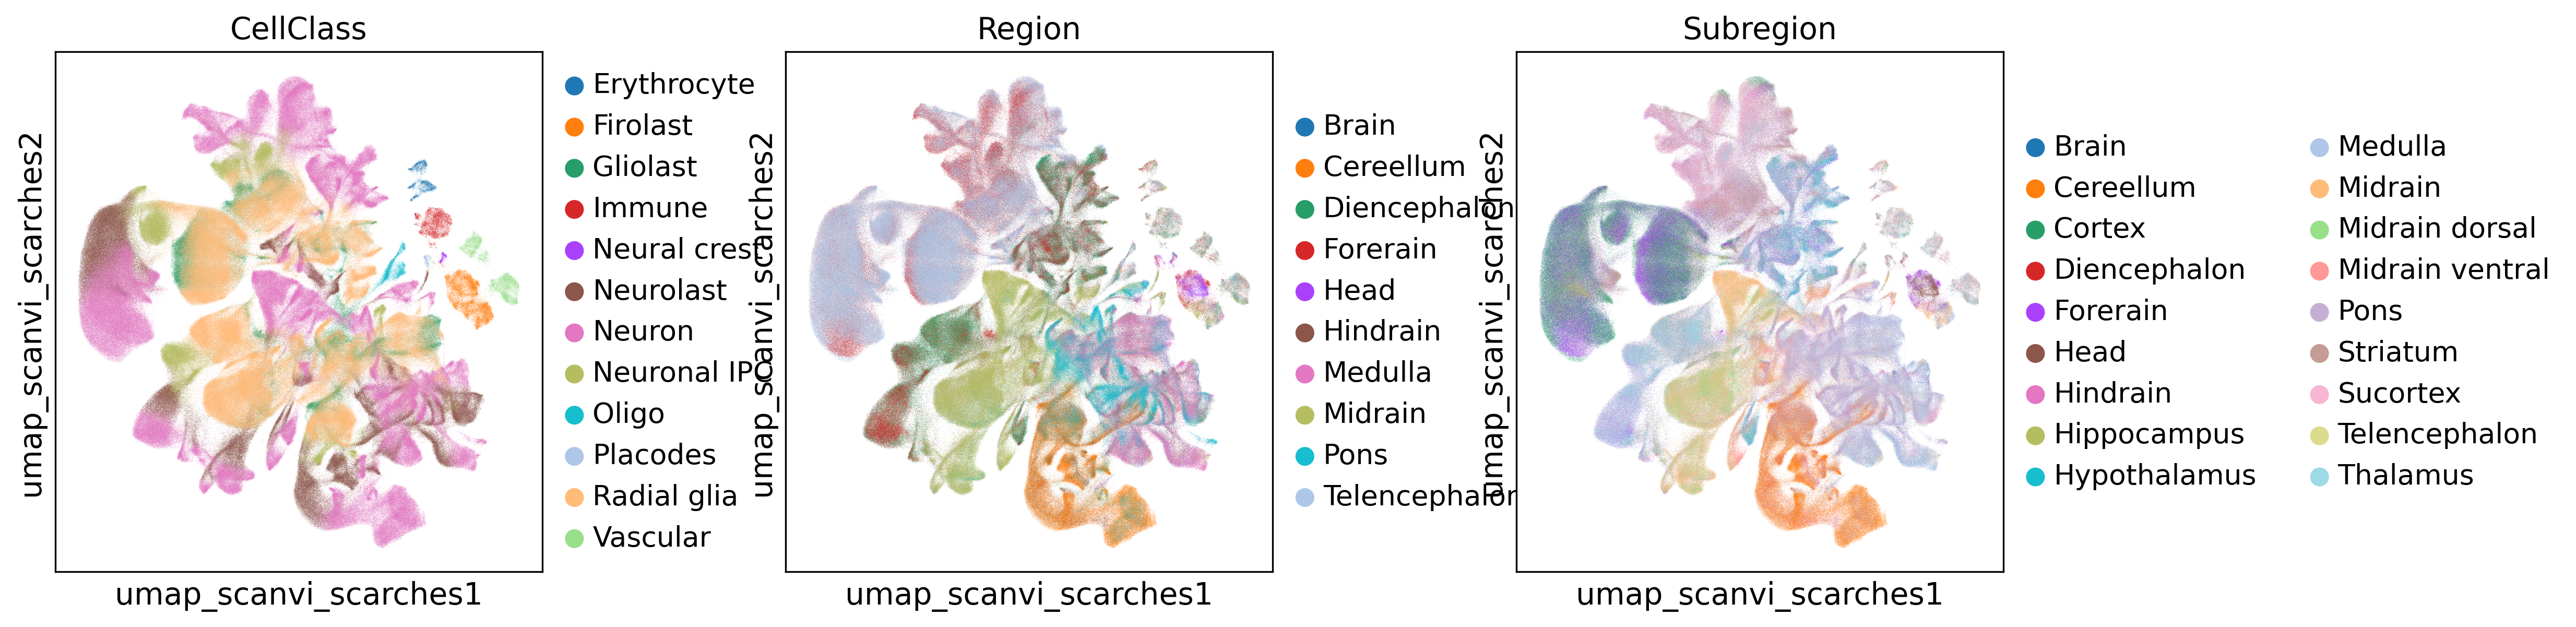

In [9]:
sc.pl.scatter(adata, basis="umap_scanvi_scarches", color=["CellClass", "Region", "Subregion"])

In [10]:
table_s2 = pd.read_excel("/storage/data/organoid_atlas_adatas/230620_braun_data/table_S2.xlsx", sheet_name="Sheet1")

In [13]:
table_s2[table_s2["Class"] == "Neuron"]["AutoAnnotation"].str.count("NT-").value_counts(sort=True)

1    194
2     13
0     10
3      1
Name: AutoAnnotation, dtype: int64

In [14]:
table_s2

PoolOrder PoolCleanOrder  TopLevelOrder  TopLevelCluster  SubCluster  \
0            0            575            276               14          15   
1            1             --            347               17           8   
2            2             --            346               17           7   
3            3             --            345               17           6   
4            4             --            344               17           5   
..         ...            ...            ...              ...         ...   
698        698            245            483               26          14   
699        699             --            476               26           7   
700        700            241            478               26           9   
701        701             --            479               26          10   
702        702            242            477               26           8   

     NCells   AutoClass   Class Subclass  Cycling  ... MeanCellCycleScore  \
0      2387      Neuron  Neuron   Neuron    False  ...           0.001869   
1       102  Neuroblast  Failed   Failed    False  ...           0.001790   
2       100  Neuroblast  Failed   Failed    False  ...           0.001800   
3        54  Neuroblast  Failed   Failed    False  ...           0.003312   
4       107  Neuroblast  Failed   Failed    False  ...           0.002544   
..      ...         ...     ...      ...      ...  ...                ...   
698     432      Immune  Immune   Immune     True  ...           0.014385   
699      33      Immune  Failed   Failed    False  ...           0.003257   
700     540      Immune  Immune   Immune    False  ...           0.003289   
701      41  Fibroblast  Failed   Failed    False  ...           0.003847   
702     643      Immune  Immune   Immune    False  ...           0.003396   

    MeanDoubletScore                                   TopLevelEnriched  \
0           0.163664  TFAP2D,LHX9,C1QL4,POU4F1,MAB21L1,OBI1-AS1,EBF2...   
1           0.215119  HRK,ACTC1,GNG8,NWD2,CPNE9,SHOX2,AL137139.2,COL...   
2           0.202511  HRK,ACTC1,GNG8,NWD2,CPNE9,SHOX2,AL137139.2,COL...   
3           0.232875  HRK,ACTC1,GNG8,NWD2,CPNE9,SHOX2,AL137139.2,COL...   
4           0.173229  HRK,ACTC1,GNG8,NWD2,CPNE9,SHOX2,AL137139.2,COL...   
..               ...                                                ...   
698         0.166793  SPP1,C1QC,AIF1,TYROBP,C1QB,CCL3,C1QA,P2RY12,CC...   
699         0.112663  SPP1,C1QC,AIF1,TYROBP,C1QB,CCL3,C1QA,P2RY12,CC...   
700         0.141962  SPP1,C1QC,AIF1,TYROBP,C1QB,CCL3,C1QA,P2RY12,CC...   
701         0.099029  SPP1,C1QC,AIF1,TYROBP,C1QB,CCL3,C1QA,P2RY12,CC...   
702         0.100018  SPP1,C1QC,AIF1,TYROBP,C1QB,CCL3,C1QA,P2RY12,CC...   

                                        SubsetEnriched  \
0    NRP2,NWD2,GNG8,MMRN1,CPNE4,CDH8,AC093866.1,CRH...   
1    SNCG,NWD2,GPC3,OBI1-AS1,CHRNB3,ONECUT1,PCOLCE2...   
2    GRIP2,SUSD4,AC135782.1,LINC00290,ADAM11,AC0041...   
3    DLX2,DLX6-AS1,FOXG1-AS1,LINC01551,GAD2,FOXG1,D...   
4    LINC02759,AC021723.2,LINC01482,CRAT37,TMEM235,...   
..                                                 ...   
698  RRM2,SPC25,KIF18B,AURKB,NDC80,MELK,MKI67,ANLN,...   
699  MT1G,HBE1,MT1H,MT2A,MT1X,TNFSF15,MT1F,SLC13A1,...   
700  F13A1,SELENOP,COLEC12,SIGLEC1,LILRB5,TIMD4,CD2...   
701  LUM,COL3A1,TAGLN,COL1A1,DCN,COL1A2,IGF2,COL6A2...   
702  DEFA1,MPO,S100A12,FCN1,LYZ,HLA-DRB5,HLA-DRB1,H...   

                                          PoolEnriched  \
0    GNG8,NWD2,CPNE9,POU4F1,OBI1-AS1,SNCG,AC093866....   
1    NWD2,GNG8,CPNE9,CPNE4,POU4F1,OBI1-AS1,CHRNB3,H...   
2    CPNE9,CPNE4,NWD2,HRK,CNTN2,GNG8,AL137139.2,COL...   
3    GNG8,CPNE9,HRK,CNTN2,AC105450.1,AC093503.2,MDG...   
4    ACTC1,HRK,GNG8,CNTN2,TESC,TPPP3,SHOX2,MDGA1,AL...   
..                                                 ...   
698  CX3CR1,C3,AIF1,C1QC,C1QB,P2RY12,SAMSN1,APBB1IP...   
699  C1QC,HMOX1,C1QB,TYROBP,AIF1,TREM2,SPP1,C1QA,VS...   
700  LYVE1,RNASE1,F13A1,MRC1,CD14,M

In [15]:
l = [i.split(" | ") for i in table_s2[table_s2["Class"].isin(["Neuron", "Neuroblast"])]["AutoAnnotation"]]
sorted(set([i for j in l for i in j]))

['GBL',
 'HB-OTV',
 'M-ERY',
 'NBL',
 'NEUR',
 'NP-GNRH',
 'NP-HCRT',
 'NP-POMC',
 'NP-TRH',
 'NT-CHOL',
 'NT-GABA',
 'NT-GLY',
 'NT-SER',
 'NT-VGLUT1',
 'NT-VGLUT2',
 'NT-VGLUT3',
 'O-HEM',
 'OPC',
 'P-DLGE',
 'P-FP1',
 'P-PALL',
 'P-PALL-M',
 'P-SUBPALL',
 'P-TEL',
 'P-VLGE',
 'PREOPC',
 'RGL',
 'S-CC',
 'S-G1S',
 'S-G2M',
 'TH-RETN']

In [16]:
ts = table_s2.set_index("PoolCleanOrder").to_dict()["AutoAnnotation"]
for nt in ['NT-CHOL', 'NT-GABA', 'NT-GLY', 'NT-SER', 'NT-VGLUT1', 'NT-VGLUT2', 'NT-VGLUT3']:
    adata.obs[nt] = [nt in ts[i] for i in adata.obs["Clusters"]]

In [31]:
adata.obs[['NT-CHOL', 'NT-GABA', 'NT-GLY', 'NT-SER', 'NT-VGLUT1', 'NT-VGLUT2', 'NT-VGLUT3']].to_csv("/storage/data/organoid_atlas_adatas/230620_braun_data/ntt_annotation.tsv", sep="\t")